In [2]:
from __future__ import division

import torch 
import torch.nn as nn
import torch.nn.functional as F 
from torch.autograd import Variable
import numpy as np
from util import * 



def get_test_input(img):
    img = cv2.resize(img, (416,416))          #Resize to the input dimension
    img_ =  img[:,:,::-1].transpose((2,0,1))  # BGR -> RGB | H X W C -> C X H X W 
    img_ = img_[np.newaxis,:,:,:]/255.0       #Add a channel at 0 (for batch) | Normalise
    img_ = torch.from_numpy(img_).float()     #Convert to float
    img_ = Variable(img_)                     # Convert to Variable
    return img_

def parse_cfg(cfgfile):
  
    file = open(cfgfile, 'r')
    lines = file.read().split('\n')                        # store the lines in a list
    lines = [x for x in lines if len(x) > 0]               # get read of the empty lines 
    lines = [x for x in lines if x[0] != '#']              # get rid of comments
    lines = [x.rstrip().lstrip() for x in lines]           # get rid of fringe whitespaces
    
    block = {}
    blocks = []
    
    for line in lines:
        if line[0] == "[":               # This marks the start of a new block
            if len(block) != 0:          # If block is not empty, implies it is storing values of previous block.
                blocks.append(block)     # add it the blocks list
                block = {}               # re-init the block
            block["type"] = line[1:-1].rstrip()     
        else:
            key,value = line.split("=") 
            block[key.rstrip()] = value.lstrip()
    blocks.append(block)
    
    return blocks


class EmptyLayer(nn.Module):
    def __init__(self):
        super(EmptyLayer, self).__init__()
        

class DetectionLayer(nn.Module):
    def __init__(self, anchors):
        super(DetectionLayer, self).__init__()
        self.anchors = anchors



def create_modules(blocks):
    net_info = blocks[0]     #Captures the information about the input and pre-processing    
    module_list = nn.ModuleList()
    prev_filters = 3
    output_filters = []
    
    for index, x in enumerate(blocks[1:]):
        module = nn.Sequential()
    
        #check the type of block
        #create a new module for the block
        #append to module_list
        
        #If it's a convolutional layer
        if (x["type"] == "convolutional"):
            #Get the info about the layer
            activation = x["activation"]
            try:
                batch_normalize = int(x["batch_normalize"])
                bias = False
            except:
                batch_normalize = 0
                bias = True
        
            filters= int(x["filters"])
            padding = int(x["pad"])
            kernel_size = int(x["size"])
            stride = int(x["stride"])
        
            if padding:
                pad = (kernel_size - 1) // 2
            else:
                pad = 0
        
            #Add the convolutional layer
            conv = nn.Conv2d(prev_filters, filters, kernel_size, stride, pad, bias = bias)
            module.add_module("conv_{0}".format(index), conv)
        
            #Add the Batch Norm Layer
            if batch_normalize:
                bn = nn.BatchNorm2d(filters)
                module.add_module("batch_norm_{0}".format(index), bn)
        
            #Check the activation. 
            #It is either Linear or a Leaky ReLU for YOLO
            if activation == "leaky":
                activn = nn.LeakyReLU(0.1, inplace = True)
                module.add_module("leaky_{0}".format(index), activn)
        
            #If it's an upsampling layer
            #We use Bilinear2dUpsampling
        elif (x["type"] == "upsample"):
            stride = int(x["stride"])
            upsample = nn.Upsample(scale_factor = 2, mode = "nearest")
            module.add_module("upsample_{}".format(index), upsample)
                
        #If it is a route layer
        elif (x["type"] == "route"):
            x["layers"] = x["layers"].split(',')
            #Start  of a route
            start = int(x["layers"][0])
            #end, if there exists one.
            try:
                end = int(x["layers"][1])
            except:
                end = 0
            #Positive anotation
            if start > 0: 
                start = start - index
            if end > 0:
                end = end - index
            route = EmptyLayer()
            module.add_module("route_{0}".format(index), route)
            if end < 0:
                filters = output_filters[index + start] + output_filters[index + end]
            else:
                filters= output_filters[index + start]
    
        #shortcut corresponds to skip connection
        elif x["type"] == "shortcut":
            shortcut = EmptyLayer()
            module.add_module("shortcut_{}".format(index), shortcut)
            
        #Yolo is the detection layer
        elif x["type"] == "yolo":
            mask = x["mask"].split(",")
            mask = [int(x) for x in mask]
    
            anchors = x["anchors"].split(",")
            anchors = [int(a) for a in anchors]
            anchors = [(anchors[i], anchors[i+1]) for i in range(0, len(anchors),2)]
            anchors = [anchors[i] for i in mask]
    
            detection = DetectionLayer(anchors)
            module.add_module("Detection_{}".format(index), detection)
                              
        module_list.append(module)
        prev_filters = filters
        output_filters.append(filters)
        
    return (net_info, module_list)

class Darknet(nn.Module):
    def __init__(self, cfgfile):
        super(Darknet, self).__init__()
        self.blocks = parse_cfg(cfgfile)
        self.net_info, self.module_list = create_modules(self.blocks)
        
    def forward(self, x, CUDA):
        modules = self.blocks[1:]
        outputs = {}   #We cache the outputs for the route layer
        
        write = 0
        for i, module in enumerate(modules):        
            module_type = (module["type"])
            
            if module_type == "convolutional" or module_type == "upsample":
                x = self.module_list[i](x)
    
            elif module_type == "route":
                layers = module["layers"]
                layers = [int(a) for a in layers]
    
                if (layers[0]) > 0:
                    layers[0] = layers[0] - i
    
                if len(layers) == 1:
                    x = outputs[i + (layers[0])]
    
                else:
                    if (layers[1]) > 0:
                        layers[1] = layers[1] - i
    
                    map1 = outputs[i + layers[0]]
                    map2 = outputs[i + layers[1]]
                    x = torch.cat((map1, map2), 1)
                
    
            elif  module_type == "shortcut":
                from_ = int(module["from"])
                x = outputs[i-1] + outputs[i+from_]
    
            elif module_type == 'yolo':        
                anchors = self.module_list[i][0].anchors
                #Get the input dimensions
                inp_dim = int (self.net_info["height"])
        
                #Get the number of classes
                num_classes = int (module["classes"])
        
                #Transform 
                x = x.data
                x = predict_transform(x, inp_dim, anchors, num_classes, CUDA)
                if not write:              #if no collector has been intialised. 
                    detections = x
                    write = 1
        
                else:       
                    detections = torch.cat((detections, x), 1)
        
            outputs[i] = x
        
        return detections


    def load_weights(self, weightfile):
        #Open the weights file
        fp = open(weightfile, "rb")
    
        #The first 5 values are header information 
        # 1. Major version number
        # 2. Minor Version Number
        # 3. Subversion number 
        # 4,5. Images seen by the network (during training)
        header = np.fromfile(fp, dtype = np.int32, count = 5)
        self.header = torch.from_numpy(header)
        self.seen = self.header[3]   
        
        weights = np.fromfile(fp, dtype = np.float32)
        
        ptr = 0
        for i in range(len(self.module_list)):
            module_type = self.blocks[i + 1]["type"]
    
            #If module_type is convolutional load weights
            #Otherwise ignore.
            
            if module_type == "convolutional":
                model = self.module_list[i]
                try:
                    batch_normalize = int(self.blocks[i+1]["batch_normalize"])
                except:
                    batch_normalize = 0
            
                conv = model[0]
                
                
                if (batch_normalize):
                    bn = model[1]
        
                    #Get the number of weights of Batch Norm Layer
                    num_bn_biases = bn.bias.numel()
        
                    #Load the weights
                    bn_biases = torch.from_numpy(weights[ptr:ptr + num_bn_biases])
                    ptr += num_bn_biases
        
                    bn_weights = torch.from_numpy(weights[ptr: ptr + num_bn_biases])
                    ptr  += num_bn_biases
        
                    bn_running_mean = torch.from_numpy(weights[ptr: ptr + num_bn_biases])
                    ptr  += num_bn_biases
        
                    bn_running_var = torch.from_numpy(weights[ptr: ptr + num_bn_biases])
                    ptr  += num_bn_biases
        
                    #Cast the loaded weights into dims of model weights. 
                    bn_biases = bn_biases.view_as(bn.bias.data)
                    bn_weights = bn_weights.view_as(bn.weight.data)
                    bn_running_mean = bn_running_mean.view_as(bn.running_mean)
                    bn_running_var = bn_running_var.view_as(bn.running_var)
        
                    #Copy the data to model
                    bn.bias.data.copy_(bn_biases)
                    bn.weight.data.copy_(bn_weights)
                    bn.running_mean.copy_(bn_running_mean)
                    bn.running_var.copy_(bn_running_var)
                
                else:
                    #Number of biases
                    num_biases = conv.bias.numel()
                
                    #Load the weights
                    conv_biases = torch.from_numpy(weights[ptr: ptr + num_biases])
                    ptr = ptr + num_biases
                
                    #reshape the loaded weights according to the dims of the model weights
                    conv_biases = conv_biases.view_as(conv.bias.data)
                
                    #Finally copy the data
                    conv.bias.data.copy_(conv_biases)
                    
                #Let us load the weights for the Convolutional layers
                num_weights = conv.weight.numel()
                
                #Do the same as above for weights
                conv_weights = torch.from_numpy(weights[ptr:ptr+num_weights])
                ptr = ptr + num_weights
                
                conv_weights = conv_weights.view_as(conv.weight.data)
                conv.weight.data.copy_(conv_weights)




In [4]:
blocks = parse_cfg("cfg/yolov3.cfg")
print(create_modules(blocks))


({'type': 'net', 'batch': '1', 'subdivisions': '1', 'width': '416', 'height': '416', 'channels': '3', 'momentum': '0.9', 'decay': '0.0005', 'angle': '0', 'saturation': '1.5', 'exposure': '1.5', 'hue': '.1', 'learning_rate': '0.001', 'burn_in': '1000', 'max_batches': '500200', 'policy': 'steps', 'steps': '400000,450000', 'scales': '.1,.1'}, ModuleList(
  (0): Sequential(
    (conv_0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (batch_norm_0): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (leaky_0): LeakyReLU(negative_slope=0.1, inplace=True)
  )
  (1): Sequential(
    (conv_1): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (batch_norm_1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (leaky_1): LeakyReLU(negative_slope=0.1, inplace=True)
  )
  (2): Sequential(
    (conv_2): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
    

In [5]:
model = Darknet("cfg/yolov3.cfg")
img = cv2.imread("./test/Apple/images/b30e118385a9513a.jpg")
inp = get_test_input(img)
pred = model(inp, torch.cuda.is_available())
print (pred)

tensor([[[1.4759e+01, 1.5272e+01, 9.6689e+01,  ..., 4.9077e-01,
          5.2523e-01, 5.9423e-01],
         [1.2181e+01, 1.5336e+01, 1.3520e+02,  ..., 5.0459e-01,
          4.2520e-01, 5.1149e-01],
         [1.3730e+01, 1.5975e+01, 1.9933e+02,  ..., 4.7157e-01,
          5.2093e-01, 4.1267e-01],
         ...,
         [4.1118e+02, 4.1273e+02, 9.1097e+00,  ..., 5.4146e-01,
          5.3795e-01, 5.4437e-01],
         [4.1169e+02, 4.1157e+02, 2.1634e+01,  ..., 4.9321e-01,
          4.8579e-01, 5.6101e-01],
         [4.1173e+02, 4.1249e+02, 2.3217e+01,  ..., 4.0789e-01,
          5.6090e-01, 4.1991e-01]]])


In [44]:
pred.shape

torch.Size([1, 10647, 85])

In [6]:
from __future__ import division
import time
import torch 
import torch.nn as nn
from torch.autograd import Variable
import numpy as np
import cv2 
from util import *
import argparse
import os 
import os.path as osp
from darknet import Darknet
import pickle as pkl
import pandas as pd
import random
    
def arg_parse():
    """
    Parse arguements to the detect module
    
    """
    
    parser = argparse.ArgumentParser(description='YOLO v3 Detection Module')
   
    parser.add_argument("--images", dest = 'images', help = 
                        "Image / Directory containing images to perform detection upon",
                        default = "test2/images", type = str)
    parser.add_argument("--det", dest = 'det', help = 
                        "Image / Directory to store detections to",
                        default = "det", type = str)
    parser.add_argument("--bs", dest = "bs", help = "Batch size", default = 1)
    parser.add_argument("--confidence", dest = "confidence", help = "Object Confidence to filter predictions", default = 0.5)
    parser.add_argument("--nms_thresh", dest = "nms_thresh", help = "NMS Threshhold", default = 0.4)
    parser.add_argument("--cfg", dest = 'cfgfile', help = 
                        "Config file",
                        default = "cfg/yolov3.cfg", type = str)
    parser.add_argument("--weights", dest = 'weightsfile', help = 
                        "weightsfile",
                        default = "yolov3.weights", type = str)
    parser.add_argument("--reso", dest = 'reso', help = 
                        "Input resolution of the network. Increase to increase accuracy. Decrease to increase speed",
                        default = "416", type = str)
    
    return parser.parse_known_args()
    
args,unknown = arg_parse()
images = args.images
batch_size = int(args.bs)
confidence = float(args.confidence)
nms_thesh = float(args.nms_thresh)
start = 0
CUDA = torch.cuda.is_available()



num_classes = 80
classes = load_classes("data/coco.names")



#Set up the neural network
print("Loading network.....")
model = Darknet(args.cfgfile)
model.load_weights(args.weightsfile)
print("Network successfully loaded")

model.net_info["height"] = args.reso
inp_dim = int(model.net_info["height"])
assert inp_dim % 32 == 0 
assert inp_dim > 32

#If there's a GPU availible, put the model on GPU
if CUDA:
    model.cuda()


#Set the model in evaluation mode
model.eval()

read_dir = time.time()
#Detection phase
try:
    imlist = [osp.join(osp.realpath('.'), images, img) for img in os.listdir(images) if os.path.splitext(img)[1] == '.png' or os.path.splitext(img)[1] =='.jpeg' or os.path.splitext(img)[1] =='.jpg']
except NotADirectoryError:
    imlist = []
    imlist.append(osp.join(osp.realpath('.'), images))
except FileNotFoundError:
    print ("No file or directory with the name {}".format(images))
    exit()
    
if not os.path.exists(args.det):
    os.makedirs(args.det)
print(imlist)
load_batch = time.time()
loaded_ims = [cv2.imread(x) for x in imlist]

#print(imlist)

im_batches = list(map(prep_image, loaded_ims, [inp_dim for x in range(len(imlist))]))
im_dim_list = [(x.shape[1], x.shape[0]) for x in loaded_ims]
im_dim_list = torch.FloatTensor(im_dim_list).repeat(1,2)


leftover = 0
if (len(im_dim_list) % batch_size):
    leftover = 1

if batch_size != 1:
    num_batches = len(imlist) // batch_size + leftover            
    im_batches = [torch.cat((im_batches[i*batch_size : min((i +  1)*batch_size,
                        len(im_batches))]))  for i in range(num_batches)]  

write = 0


if CUDA:
    im_dim_list = im_dim_list.cuda()
    
start_det_loop = time.time()
for i, batch in enumerate(im_batches):
#load the image 
    start = time.time()
    if CUDA:
        batch = batch.cuda()
    with torch.no_grad():
        prediction = model(Variable(batch), CUDA)
        
    prediction = write_results(prediction, confidence, num_classes, nms_conf = nms_thesh)

    end = time.time()

    if type(prediction) == int:

        for im_num, image in enumerate(imlist[i*batch_size: min((i +  1)*batch_size, len(imlist))]):
            im_id = i*batch_size + im_num
            print("{0:20s} predicted in {1:6.3f} seconds".format(image.split("/")[-1], (end - start)/batch_size))
            print("{0:20s} {1:s}".format("Objects Detected:", ""))
            print("----------------------------------------------------------")
        continue

    prediction[:,0] += i*batch_size    #transform the atribute from index in batch to index in imlist 

    if not write:                      #If we have't initialised output
        output = prediction  
        write = 1
    else:
        output = torch.cat((output,prediction))

    for im_num, image in enumerate(imlist[i*batch_size: min((i +  1)*batch_size, len(imlist))]):
        im_id = i*batch_size + im_num
        objs = [classes[int(x[-1])] for x in output if int(x[0]) == im_id]
        print("{0:20s} predicted in {1:6.3f} seconds".format(image.split("/")[-1], (end - start)/batch_size))
        print("{0:20s} {1:s}".format("Objects Detected:", " ".join(objs)))
        print("----------------------------------------------------------")

    if CUDA:
        torch.cuda.synchronize()       
try:
    output
except NameError:
    print ("No detections were made")
    exit()

im_dim_list = torch.index_select(im_dim_list, 0, output[:,0].long())

scaling_factor = torch.min(416/im_dim_list,1)[0].view(-1,1)


output[:,[1,3]] -= (inp_dim - scaling_factor*im_dim_list[:,0].view(-1,1))/2
output[:,[2,4]] -= (inp_dim - scaling_factor*im_dim_list[:,1].view(-1,1))/2



output[:,1:5] /= scaling_factor

for i in range(output.shape[0]):
    output[i, [1,3]] = torch.clamp(output[i, [1,3]], 0.0, im_dim_list[i,0])
    output[i, [2,4]] = torch.clamp(output[i, [2,4]], 0.0, im_dim_list[i,1])
    

output_recast = time.time()
class_load = time.time()
colors = pkl.load(open("pallete", "rb"))

draw = time.time()

def write(x, results,imlist):
    c1 = tuple(x[1:3].int())
    c2 = tuple(x[3:5].int())
    img = results[int(x[0])]
    cls = int(x[-1])
    color = random.choice(colors)
    label = "{0}".format(classes[cls])
    cv2.rectangle(img, c1, c2,color, 1)
    t_size = cv2.getTextSize(label, cv2.FONT_HERSHEY_PLAIN, 1 , 1)[0]
    c2 = c1[0] + t_size[0] + 3, c1[1] + t_size[1] + 4
    cv2.rectangle(img, c1, c2,color, -1)
    cv2.putText(img, label, (c1[0], c1[1] + t_size[1] + 4), cv2.FONT_HERSHEY_PLAIN, 1, [225,255,255], 1);
    return img

list(map(lambda x: write(x, loaded_ims,imlist), output))
det_names = pd.Series(imlist).apply(lambda x: "{}/det_{}".format(args.det,x.split("/")[-1]))

list(map(cv2.imwrite, det_names, loaded_ims))


end = time.time()

print("SUMMARY")
print("----------------------------------------------------------")
print("{:25s}: {}".format("Task", "Time Taken (in seconds)"))
print()
print("{:25s}: {:2.3f}".format("Reading addresses", load_batch - read_dir))
print("{:25s}: {:2.3f}".format("Loading batch", start_det_loop - load_batch))
print("{:25s}: {:2.3f}".format("Detection (" + str(len(imlist)) +  " images)", output_recast - start_det_loop))
print("{:25s}: {:2.3f}".format("Output Processing", class_load - output_recast))
print("{:25s}: {:2.3f}".format("Drawing Boxes", end - draw))
print("{:25s}: {:2.3f}".format("Average time_per_img", (end - load_batch)/len(imlist)))
print("----------------------------------------------------------")


torch.cuda.empty_cache()
    


Loading network.....
Network successfully loaded
['/Users/muskankuchhal/Desktop/YOLO_v3_tutorial_from_scratch-master/test2/images/1266926b5a8462fc.jpg', '/Users/muskankuchhal/Desktop/YOLO_v3_tutorial_from_scratch-master/test2/images/0b08be997c493540.jpg', '/Users/muskankuchhal/Desktop/YOLO_v3_tutorial_from_scratch-master/test2/images/07b1dc7ebcd61980.jpg', '/Users/muskankuchhal/Desktop/YOLO_v3_tutorial_from_scratch-master/test2/images/57e2f8bf9328a0ef.jpg', '/Users/muskankuchhal/Desktop/YOLO_v3_tutorial_from_scratch-master/test2/images/5175542fe8bbe3a2.jpg', '/Users/muskankuchhal/Desktop/YOLO_v3_tutorial_from_scratch-master/test2/images/7654b1d7f9fe6ade.jpg', '/Users/muskankuchhal/Desktop/YOLO_v3_tutorial_from_scratch-master/test2/images/e0d35f4ba43e0bbe.jpg', '/Users/muskankuchhal/Desktop/YOLO_v3_tutorial_from_scratch-master/test2/images/ff67985e854fb528.jpg', '/Users/muskankuchhal/Desktop/YOLO_v3_tutorial_from_scratch-master/test2/images/a6d121067107138a.jpg', '/Users/muskankuchhal/D

e0d35f4ba43e0bbe.jpg predicted in  1.284 seconds
Objects Detected:    chair chair chair refrigerator
----------------------------------------------------------
ff67985e854fb528.jpg predicted in  1.291 seconds
Objects Detected:    bench chair
----------------------------------------------------------
a6d121067107138a.jpg predicted in  1.587 seconds
Objects Detected:    hair drier
----------------------------------------------------------
0115ad2fae23ad7a.jpg predicted in  1.307 seconds
Objects Detected:    book book book book book book book book book
----------------------------------------------------------
9fb5c698d31c7a30.jpg predicted in  1.279 seconds
Objects Detected:    cup spoon diningtable
----------------------------------------------------------
00db845c30d8aa24.jpg predicted in  1.283 seconds
Objects Detected:    giraffe
----------------------------------------------------------
d6ef4f0b84f48767.jpg predicted in  1.284 seconds
Objects Detected:    person person dog
---------

514ac3f662cd8df4.jpg predicted in  1.283 seconds
Objects Detected:    bottle cup spoon bowl apple sandwich
----------------------------------------------------------
c8833afa185042a9.jpg predicted in  1.297 seconds
Objects Detected:    cat cat cat cat dog dog dog
----------------------------------------------------------
2803fa4cd2016a14.jpg predicted in  1.279 seconds
Objects Detected:    dog bear giraffe
----------------------------------------------------------
e5be76139167afa1.jpg predicted in  1.283 seconds
Objects Detected:    person person person person person person person person person person person person person cup chair chair chair chair chair chair diningtable clock
----------------------------------------------------------
d146e36c3b6442ba.jpg predicted in  1.274 seconds
Objects Detected:    spoon
----------------------------------------------------------
0eb4d8c71846da25.jpg predicted in  1.290 seconds
Objects Detected:    person person apple carrot carrot
--------------

In [7]:
def readTextFile(path):
    with open(path) as f:
        r = f.read()
    return r

In [10]:
r  = readTextFile("./test/Apple/Label/b30e118385a9513a.txt")
r = r.split('\n')[:-1]
r[0]

'Apple 419.199744 654.400512 648.0 888.000512'

In [11]:
import os
def Load():
    count_gbox=0
    test_data={}
    for filename in os.listdir("./test2/label"):
        name=filename.split(".")[0]
        folder_path=os.path.join('./test2/label',filename)
        content = open(folder_path, 'r')

        for tag in content:
            l = tag.split()
            count_gbox=count_gbox+1
            test_data.setdefault(name, []).append(l)
            
    return test_data,count_gbox    
test_data,count_gbox=Load()
print(count_gbox)
#print(test_data)

176


In [13]:
print(test_data['221f2b6febc03c19'])

[['Apple', '723.6751360000001', '10.841594999999998', '920.876032', '233.09411']]


In [14]:
print(output.shape)

torch.Size([321, 8])


In [15]:
output=torch.stack(sorted(output, key=lambda output: output[5],reverse=True))
print(output[0][5])

tensor(1.0000)


In [16]:
data_frame=[]
for bbox in output:
    image_name=imlist[int(bbox[0])].split("/")[-1].split('.')[0]
    cls=classes[int(bbox[-1])]
    data=[]
    used={}
    max_iou=0.0
    max_gbox=()
    #print(image_name,cls.lower(),":")
    for gbox in test_data[image_name]:
        if(gbox[0].lower()==cls.lower()):
            boxA=np.array([float(i) for i in gbox[1:]])
            boxB=bbox[1:5].numpy()
            xA = max(boxA[0], boxB[0])
            yA = max(boxA[1], boxB[1])
            xB = min(boxA[2], boxB[2])
            yB = min(boxA[3], boxB[3])
            # compute the area of intersection rectangle
            interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)
            # compute the area of both the prediction and ground-truth
            # rectangles
            boxAArea = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)
            boxBArea = (boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1)
            # compute the intersection over union by taking the intersection
            # area and dividing it by the sum of prediction + ground-truth
            # areas - the interesection area
            iou = interArea / float(boxAArea + boxBArea - interArea)
            # return the intersection over union value
            if iou>max_iou and iou>0.5:
                max_iou=iou
                max_gbox=tuple(gbox)
    if(used.__contains__(max_gbox) or max_iou==0.0):
        data.extend([cls,bbox.numpy()[5],0,1])
    elif (used.__contains__(max_gbox)==False):
        used[max_gbox]=bbox
        data.extend([cls,bbox.numpy()[5],1,0])
    data_frame.append(data)

tp=0
fp=0
for i in data_frame:
    tp=tp+i[2]
    fp=fp+i[3]
    i.extend([tp,fp,tp/(tp+fp),tp/count_gbox])
print(data_frame[:5]) #class, objectness_score, tp,fp,acculmulated tp, accumulated fp,precision,recall


[['giraffe', 0.9999672, 1, 0, 1, 0, 1.0, 0.005681818181818182], ['spoon', 0.9999516, 1, 0, 2, 0, 1.0, 0.011363636363636364], ['person', 0.99993825, 0, 1, 2, 1, 0.6666666666666666, 0.011363636363636364], ['diningtable', 0.9999238, 0, 1, 2, 2, 0.5, 0.011363636363636364], ['bench', 0.99989116, 0, 1, 2, 3, 0.4, 0.011363636363636364]]


In [17]:
data_frame[:5]

[['giraffe', 0.9999672, 1, 0, 1, 0, 1.0, 0.005681818181818182],
 ['spoon', 0.9999516, 1, 0, 2, 0, 1.0, 0.011363636363636364],
 ['person', 0.99993825, 0, 1, 2, 1, 0.6666666666666666, 0.011363636363636364],
 ['diningtable', 0.9999238, 0, 1, 2, 2, 0.5, 0.011363636363636364],
 ['bench', 0.99989116, 0, 1, 2, 3, 0.4, 0.011363636363636364]]

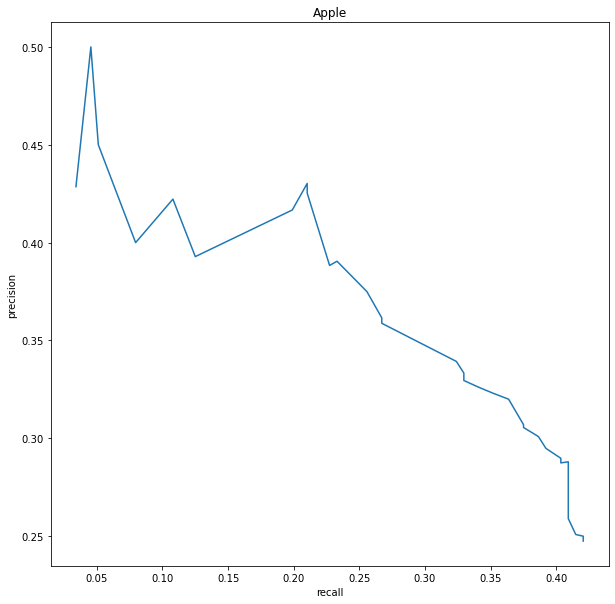

In [34]:
import matplotlib.pyplot as plt
X=[]
Y=[]
for i in data_frame:
    if i[0]=='apple':
        X.append(i[-1])
        Y.append(i[-2])
plt.figure(figsize=(10,10))
plt.plot(X,Y)
plt.ylabel('precision')
plt.xlabel('recall')
plt.title('Apple')
plt.show()

In [35]:
def integrate(x, y):
    area = np.trapz(y=y, x=x)
    return area
print(integrate(X, Y))

0.1447507755428091


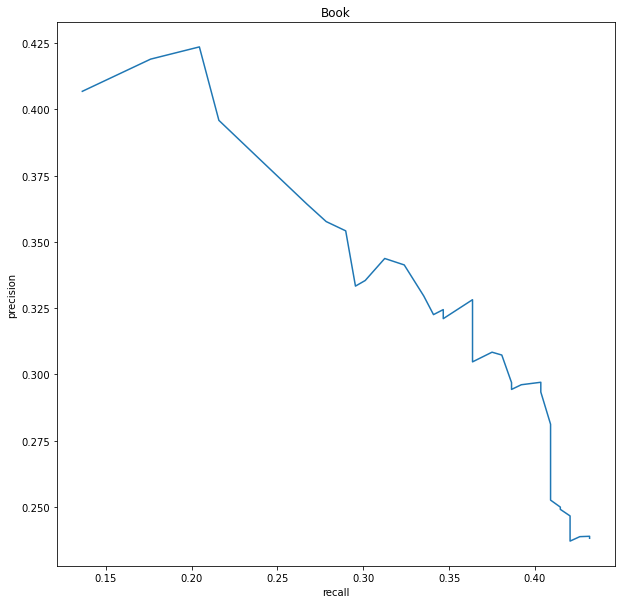

In [36]:
X=[]
Y=[]
for i in data_frame:
    if i[0]=='book':
        X.append(i[-1])
        Y.append(i[-2])
plt.figure(figsize=(10,10))
plt.plot(X,Y)
plt.ylabel('precision')
plt.xlabel('recall')
plt.title('Book')
plt.show()

In [37]:
print(integrate(X, Y))

0.1044427932082597


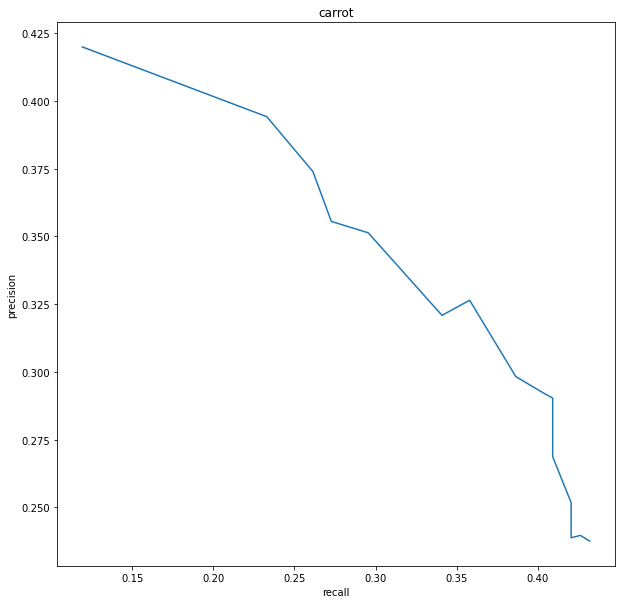

In [38]:
X=[]
Y=[]
for i in data_frame:
    if i[0]=='carrot':
        X.append(i[-1])
        Y.append(i[-2])
plt.figure(figsize=(10,10))
plt.plot(X,Y)
plt.ylabel('precision')
plt.xlabel('recall')
plt.title('carrot')
plt.show()

In [39]:
print(integrate(X, Y))

0.11137869827169777


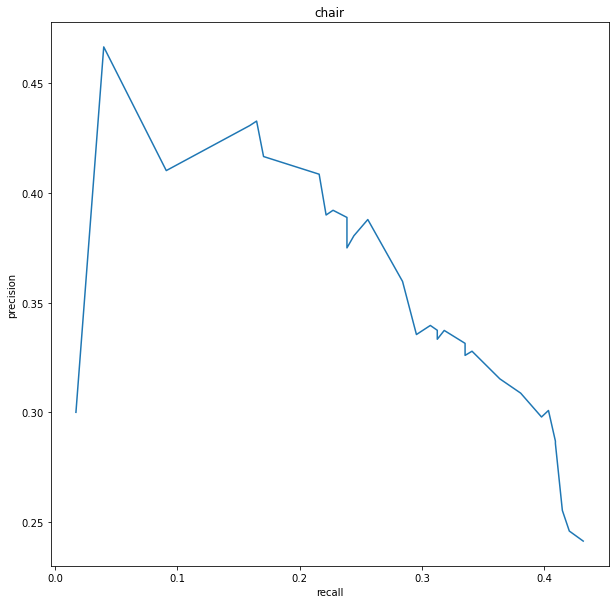

In [40]:
X=[]
Y=[]
for i in data_frame:
    if i[0]=='chair':
        X.append(i[-1])
        Y.append(i[-2])
plt.figure(figsize=(10,10))
plt.plot(X,Y)
plt.ylabel('precision')
plt.xlabel('recall')
plt.title('chair')
plt.show()

In [41]:
print(integrate(X,Y))

0.1555565062103068


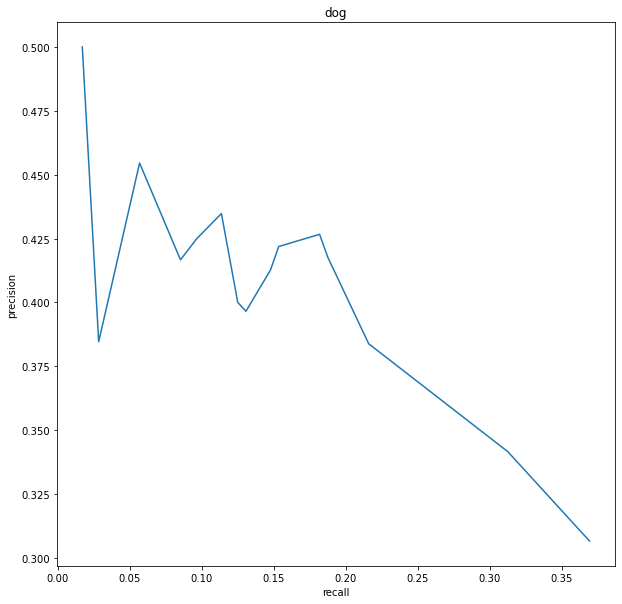

In [46]:
X=[]
Y=[]
for i in data_frame:
    if i[0]=='dog':
        X.append(i[-1])
        Y.append(i[-2])
plt.figure(figsize=(10,10))
plt.plot(X,Y)
plt.ylabel('precision')
plt.xlabel('recall')
plt.title('dog')
plt.show()

In [47]:
print(integrate(X, Y))

0.13699433600551747


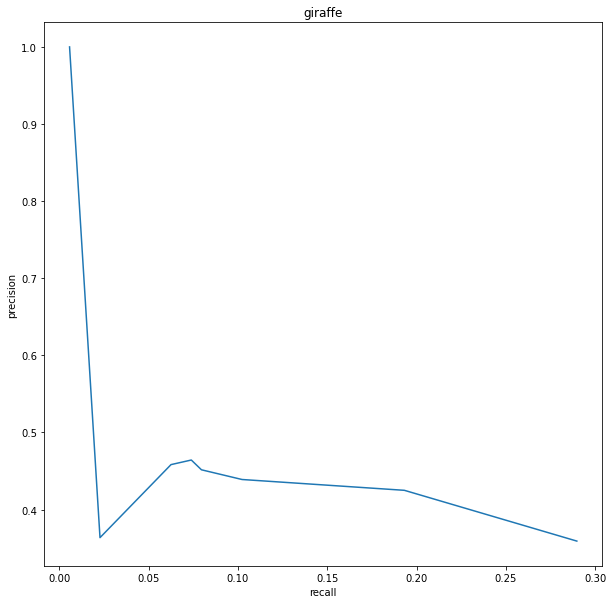

In [48]:
X=[]
Y=[]
for i in data_frame:
    if i[0]=='giraffe':
        X.append(i[-1])
        Y.append(i[-2])
plt.figure(figsize=(10,10))
plt.plot(X,Y)
plt.ylabel('precision')
plt.xlabel('recall')
plt.title('giraffe')
plt.show()

In [49]:
print(integrate(X,Y))

0.12307786052001353


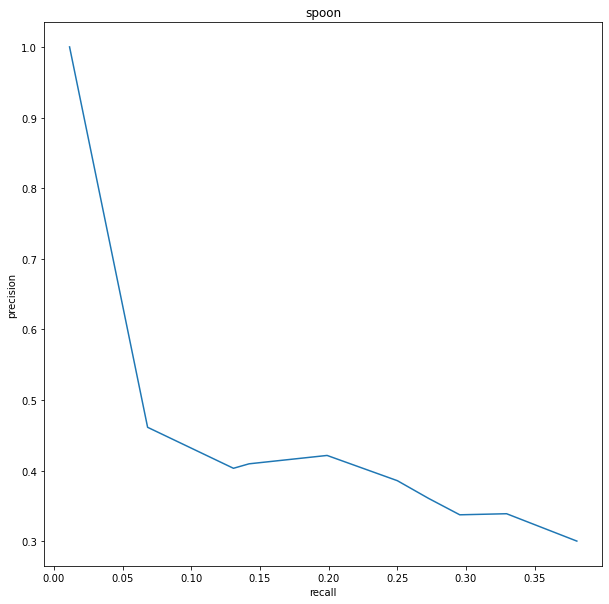

In [44]:
X=[]
Y=[]
for i in data_frame:
    if i[0]=='spoon':
        X.append(i[-1])
        Y.append(i[-2])
plt.figure(figsize=(10,10))
plt.plot(X,Y)
plt.ylabel('precision')
plt.xlabel('recall')
plt.title('spoon')
plt.show()

In [45]:
print(integrate(X,Y))

0.16176461125318775


In [51]:
from PIL import Image

In [50]:
print(test_data['40c12fc1131ee58c'])

[['Dog', '54.4', '65.993509', '1023.36', '682.3593460000001'], ['Dog', '515.84', '57.664324', '1023.36', '682.3593460000001']]


In [58]:
for bbox in output:
    image_name=imlist[int(bbox[0])].split("/")[-1].split('.')[0]
    cls=classes[int(bbox[-1])]
    if(image_name=='0fa6c8691a78b430'and cls.lower()=='dog'):
        im = Image.open('det/det_0fa6c8691a78b430.jpg') 
        left = bbox.numpy()[1]
        top = bbox.numpy()[2]
        right = bbox.numpy()[3]
        bottom = bbox.numpy()[4]
        print(left,top,right,bottom)
        im1 = im.crop((left, top, right, bottom)) 
        im1.show()
        im1=im1.save('Cropped_image.jpg')
        break
        

775.3966 683.87067 919.4307 1011.81476


In [ ]:
from PIL import Image
im = Image.open(r"C:\Users\Admin\Pictures\network.png") 
  
# Setting the points for cropped image 
left = 155
top = 65
right = 360
bottom = 270
  
# Cropped image of above dimension 
# (It will not change orginal image) 
im1 = im.crop((left, top, right, bottom)) 
  
# Shows the image in image viewer 
im1.show() 